# VQC Challenge

In this challenge, you will use [Pennylane](https://github.com/PennyLaneAI/pennylane) and [Amazon Braket](https://github.com/aws/amazon-braket-examples) to implement a variational quantum classifier (VQC) to take on a supervised learning problem based on the work of [Havlíček et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf). Complete each of the four TODOs in this notebook to construct and train a QML model to solve the binary classification task. You can use the `gen_binary.py` script to generate a new train/test dataset, and further test your model.

A central feature of Amazon Braket is that its remote simulator can execute multiple circuits in parallel. This capability can be harnessed in PennyLane during circuit training, which requires lots of variations of a circuit to be executed. Hence, the PennyLane-Braket plugin provides a method for scalable optimization of large circuits with many parameters. After validating your implementation and successfully training using a local simulator, enable [qBraid quantum jobs](https://qbraid-qbraid.readthedocs-hosted.com/en/latest/cli/jobs.html) and test your binary classifier on remote quantum hardware using the [Amazon Braket Pennylane plugin](https://github.com/aws/amazon-braket-pennylane-plugin-python). See the resources linked below for more.

*Important*:  Your final model must be tested with on a remote quantum device using the Amazon Braket Pennylane plugin. Submissions that do not interface with [Amazon Braket supported devices](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html) will not be eligible to be ranked on the leaderboard.

#### Pennylane Resources:

- [Quantum Embedding](https://pennylane.ai/qml/glossary/quantum_embedding.html)
- [Quantum Feature Map](https://pennylane.ai/qml/glossary/quantum_feature_map.html)
- [Circuit Ansatz](https://pennylane.ai/qml/glossary/circuit_ansatz.html)
- [Variational Circuit](https://pennylane.ai/qml/glossary/variational_circuit.html)
- [Quantum Gradient](https://pennylane.ai/qml/glossary/quantum_gradient.html)
- [Variational Quantum Classifier](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html)
- [PennyLane-Braket Plugin](https://amazon-braket-pennylane-plugin-python.readthedocs.io/en/latest/)
- [Computing gradients in parallel with Amazon Braket](https://pennylane.ai/qml/demos/braket-parallel-gradients.html)

#### Amazon Braket Resources:

- [Use PennyLane with Amazon Braket](https://docs.aws.amazon.com/braket/latest/developerguide/hybrid.html)
- [Amazon Braket examples: hybrid quantum algorithms](https://github.com/aws/amazon-braket-examples/tree/main/examples/hybrid_quantum_algorithms)

#### qBraid Resources:

- [qBraid demo notebooks: quantum jobs](https://github.com/qBraid/qbraid-lab-demo/blob/main/qbraid_quantum_jobs.ipynb)
- [qBraid CLI: quantum jobs commands](https://qbraid-qbraid.readthedocs-hosted.com/en/latest/cli/jobs.html)

In [1]:
!qbraid jobs enable haqs  # enable quantum jobs

/bin/bash: qbraid: command not found


In [2]:
TEAM_NAME = "Qualition"  # enter team name

In [3]:
import warnings

warnings.filterwarnings("ignore")

import csv
import json
import os
import time
from itertools import chain, combinations

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

## Load

In [4]:
# %run gen_binary.py  # uncomment to generate new train/test dataset

In [5]:
DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_samples = 200  # number of train/test samples
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data) #train_test_split was imported from sklearn.model_selection

### Build circuit

In [6]:
def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])



def feature_map(x):
    """Short depth feature map with entanglement

    Args:
        x : shape (3,) tensor containing one encoded data vector
    """

    # # A simplification of the feature map circuit used by the old gen_binary.py
    # qml.RX(x[0], wires = 0)
    # qml.RX(x[1] + x[2], wires = 1)
    
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(-2 * x[0], wires=0)
    qml.RZ(-2 * x[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RZ(-2 * x[2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(-2 * x[0], wires=0)
    qml.RZ(-2 * x[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RZ(-2 * x[2], wires=1)
    qml.CNOT(wires=[0, 1])
    
    
def ansatz(params):
    """VQC ansatz using single-qubits unitaries and entangling gates.
    This is a full parametrization of 4 by 4 unitaries up to things that our measured observable Z_0 I_1 invariant.
    See figure 7 in https://arxiv.org/pdf/quant-ph/0308006.pdf

    Args:
        params : shape (12,) array containing trainable parameters
    """
    
    qml.Rot(params[0], params[1], params[2], wires = 0)
    qml.Rot(params[3], params[4], params[5], wires = 1)
    
    qml.CNOT(wires = [1,0])
    
    qml.RZ(params[6], wires = 0)
    qml.RY(params[7], wires = 1)
    
    qml.CNOT(wires = [0,1])
    
    qml.RY(params[8], wires = 1)
    
    qml.CNOT(wires = [1,0])
    
    qml.Rot(params[9], params[10], params[11], wires = 0)
    
    
    
    
def circuit(params, x):
    """Havlicek et al. variational quantum circuit

    Args:
        params : shape (12,) tensor containing trainable parameters
        x : shape (2,) tensor containing one input data vector

    Returns:
        shape(2**2,) tensor containing Z basis measurement probability on each qubit
    """

    feature_map(encode_data(x))  # prepare initial feature map state
    ansatz(params)  # apply discriminator circuit

    return qml.probs(wires=[0,1])

In [7]:
# Set up local simulator device with finite number of shots
shots = 250  # number of circuit executions.
dev_local = qml.device("default.qubit", wires=2, shots=shots)
qnode_local = qml.QNode(circuit, dev_local)

# Set up remote simulator device
# device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"   
# dev_SV1 = qml.device("braket.aws.qubit",
#                      device_arn=device_arn,
#                      wires=2,
#                      parallel=True,
#                      max_parallel=2,
#                      shots=shots)
# qnode_SV1 = qml.QNode(circuit, dev_SV1)

### Define qnode to run the above circuit in parallel

We can run several copies of the above in parallel on a single quantum circuit. We introduce a parameter `n_para` which will be the number of copies the 2-qubit feature-map plus ansatz circuit that are placed in a single circuit (and hence single qnode and single quantum task). We define a parallelized version of the above cost function that lessens the number of quantum tasks.

In [8]:
n_para = 5 # The number of copies to run in parallel

In [9]:
def encode_data_para(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (n_para, 2) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """
    x_enc = np.zeros((x.shape[0],3))
    for i, xi in enumerate(x):
        x_enc[i] = np.array([xi[0], xi[1], (np.pi - xi[0]) * (np.pi - xi[1])])
    
    return x_enc


def feature_map_para(x):
    """Short depth feature map with entanglement

    Args:
        x : shape (n_para, 3) tensor containing one encoded data vector
    """

    # # A simplification of the feature map circuit used by the old gen_binary.py
    # qml.RX(x[0], wires = 0)
    # qml.RX(x[1] + x[2], wires = 1)
    
    for i, xi in enumerate(x):
        
        qml.Hadamard(wires=0 + 2*i)
        qml.Hadamard(wires=1 + 2*i)
        qml.RZ(-2 * xi[0], wires=0 + 2*i)
        qml.RZ(-2 * xi[1], wires=1 + 2*i)
        qml.CNOT(wires=[0 + 2*i, 1 + 2*i])
        qml.RZ(-2 * xi[2], wires=1 + 2*i)
        qml.CNOT(wires=[0 + 2*i, 1 + 2*i])

        qml.Hadamard(wires=0 + 2*i)
        qml.Hadamard(wires=1 + 2*i)
        qml.RZ(-2 * xi[0], wires=0 + 2*i)
        qml.RZ(-2 * xi[1], wires=1 + 2*i)
        qml.CNOT(wires=[0 + 2*i, 1 + 2*i])
        qml.RZ(-2 * xi[2], wires=1 + 2*i)
        qml.CNOT(wires=[0 + 2*i, 1 + 2*i])
    

    
def ansatz_para(params):
    """VQC ansatz using single-qubits unitaries and entangling gates.
    This is a full parametrization of 4 by 4 unitaries up to things that our measured observable Z_0 I_1 invariant.
    See figure 7 in https://arxiv.org/pdf/quant-ph/0308006.pdf

    Args:
        params : shape (12,) array containing trainable parameters
    """
    
    for i in range(n_para):
        
        qml.Rot(params[0], params[1], params[2], wires = 0 + 2*i)
        qml.Rot(params[3], params[4], params[5], wires = 1 + 2*i)

        qml.CNOT(wires = [1 + 2*i, 0 + 2*i])

        qml.RZ(params[6], wires = 0 + 2*i)
        qml.RY(params[7], wires = 1 + 2*i)

        qml.CNOT(wires = [0 + 2*i, 1 + 2*i])

        qml.RY(params[8], wires = 1 + 2*i)

        qml.CNOT(wires = [1 + 2*i, 0 + 2*i])

        qml.Rot(params[9], params[10], params[11], wires = 0 + 2*i)
        
        
        
def circuit_para(params, x):
    """Havlicek et al. variational quantum circuit

    Args:
        params : shape (12,) tensor containing trainable parameters
        x : shape (n_para, 2) tensor containing one input data vector

    Returns:
        shape(2**2,) tensor containing Z basis measurement probability on each qubit
    """

    feature_map_para(encode_data_para(x))  # prepare initial feature map state
    ansatz_para(params)  # apply discriminator circuit

    return qml.probs(wires=[2*i for i in range(n_para)])        

In [10]:
# Set up local simulator device with finite number of shots
shots = 250  # number of circuit executions.
dev_para = qml.device("default.qubit", wires=2*n_para, shots=shots)
qnode_para = qml.QNode(circuit_para, dev_para)

## Train model

The probability that the label $m(\textbf{x}) = y$ is assigned incorrectly is approximated by

$$ \text{Pr}(\tilde{m}(\textbf{x}) \neq m(\textbf{x})) \approx \text{sig}\bigg( \frac{\sqrt{R}\big( \frac{1}{2} - \big( \hat{p}_y(\textbf{x})+ \frac{yb}{2} \big) \big)}{\sqrt{2(1-\hat{p}_y(\textbf{x}))\hat{p}_y(\textbf{x})}} \bigg) $$ 

where $\text{sig}(x) = (1+ e^{-x})^{-1}$ is the sigmoid function.

We define the empirical risk $R_{\text{emp}}(\theta)$ in terms of the error probability $\text{Pr}(\tilde{m}(\textbf{x} \neq m(\textbf{x}))$ of assigning the incorrect label, based on the decision rule $\tilde{m}(\textbf{s}) = \text{argmax}_y\{ \hat{p}_y(\textbf{s}) \}$ after R shots, averaged over the samples in the training set $T$. In the binary case this decision rule simplifies to $\tilde{m}(\textbf{x}) = y$ whenever $\hat{p}_y(\textbf{x}) > \hat{p}_{-y}(\textbf{x}) - yb$.

$$ R_{\text{emp}}(\theta) = \frac{1}{|T|} \sum_{\textbf{x} \in T} \text{Pr}(\tilde{m}(\textbf{x}) \neq m(\textbf{x})).$$

In [11]:
def err_prob(params, x, y, R, bias=0):
    """Error probability of assigning a wrong label

    Args:
        x : shape (2,) tensor containing one input data vector
        y : shape (1,) tensor containing associated label
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        R : int number of circuit evaluations (shots)
        bias : optional bias parameter in [-1,+1]

    Returns:
        probability that the VQC computed label m(x) = y' is assigned incorrectly
    """

    bprobs = qnode_local(params, x)  # probabilities for each basis state
    cprobs = (bprobs[0] + bprobs[1], bprobs[2] + bprobs[3])  # probabilities for each eigenstate of parity Z_1 I_2. (Note the change from Havlicek et al.)
    prob_correct = cprobs[int(0.5 - 0.5 * y)]  # probability of choosing correct label

    # Intermediate evaluation of equation from supplement using derived p_y(x) i.e. prob_correct
    eps = 5*10**-10
    val = (np.sqrt(R) * (0.5 - prob_correct - 0.5 * y * bias)) / (
        np.sqrt(2 * (1 - prob_correct) * prob_correct)
    + eps)
    
    return 1 / (1 + np.exp(-val))  # binomial CDF for R >> 1 approximated using sigmoid function


def cost(params, Xs, Ys, R):
    """Cost function for circuit optimization

    Args:
        params : shape (12,) tensor containing trainable parameters
        Xs : shape (n,2) tensor containing input data vectors
        Ys : shape (n,) tensor containing associated labels
        R : int number of circuit evaluations (shots)

    Returns:
        the empirical risk i.e. the error probability averaged over all data points

    """

    ep_sum = 0  # initialize error probabilities sum
    for i in range(Xs.shape[0]):  # compute sum of error probabilities over all data points
        ep_sum += err_prob(params, Xs[i], Ys[i], R)

    return ep_sum / Xs.shape[0]  # return average over all data points

We now define parallelized versions of the error and cost functions above.

In [12]:
def aux_mat(n):
    """This function constructs an auxiliary matrix used id err_prob_para to combine the computational basis probabilities into the probabilities of interest"""
    
    mat = np.zeros((n, 2**n))
    for i in range(2**n):
        mat[:,-1 - i] = np.array([(i>>(n - 1 - j)) % 2 for j in range(n)]) # The columns of mat from right to left are the list of binary digits.
    
    return mat

mat = aux_mat(n_para)

In [13]:
def err_prob_para(params, x, y, R):
    """Error probability of assigning a wrong label

    Args:
        x : shape (n_para, 2) tensor containing n_para input data vectors
        y : shape (n_para,) tensor containing the n_para associated labels
        params : shape (15,) tensor containing trainable parameters
        R : int number of circuit evaluations (shots)

    Returns:
        probabilities that the VQC computed labels m(x[i]) = y' are assigned incorrectly
    """
    
    probs = qnode_para(params, x)
    partials = mat @ probs
    probs_correct = 0.5 + y*(partials - 0.5)

    # Intermediate evaluation of equation from supplement using derived p_y(x) i.e. prob_correct
    eps = 5*10**-10
    vals = (R**0.5 * (0.5 - probs_correct)) / ((2 * (1 - probs_correct) * probs_correct)**0.5 + eps)

    return 1 / (1 + np.exp(-vals))  # binomial CDF for R >> 1 approximated using sigmoid function



def cost_para(params, Xs, Ys, R):
    """Cost function for circuit optimization

    Args:
        params : shape (12,) tensor containing trainable parameters
        Xs : shape (n, 2) tensor containing input data vectors, where n is a multiple of n_para
        Ys : shape (n,) tensor containing associated labels, where n is a multiple of n_para
        R : int number of circuit evaluations (shots)

    Returns:
        the empirical risk i.e. the error probability averaged over all data points

    """
    
    n = Xs.shape[0]
    assert n % n_para == 0, 'Number of input datapoints is not a multiple of n_para.'
    
    k = n//n_para # number of calls to the qnode
    
    ep_sum = 0
    for i in range(k):
        ep_sum += np.sum(err_prob_para(params, Xs[n_para*i:n_para*(i + 1)], Ys[n_para*i:n_para*(i + 1)], R))
    
    return ep_sum/n

In [14]:
# np.random.seed(68) # uncomment to fix the random choice of parameters
params = 2*np.pi*np.random.rand(12, requires_grad=True) # random initial circuit parameters

In [15]:
# Gradient-based training

max_iterations = 60  # maximum number of training iterations
max_quantum_cost = 25 # will stop iterating once max_quantum_cost has been surpassed
batch_size = 2

cost_current = cost(params, X_train, Y_train, shots)
costs = [cost_current]
cost_estimates = [] # the costs resulting from the optimizers call of the function. We can use these to update hyperparameters.
ave_cost_estimates = []
times = []
quantum_costs = [0]

opt = qml.GradientDescentOptimizer()

cost_estimate = 0.5 # initialize before we have a chance to call the qnode
ave_cost_estimate = 0.5
for i in tqdm(range(max_iterations), desc="training", leave=False):
    
    if np.log(ave_cost_estimate) > -2:
        opt.stepsize = 1
    elif np.log(ave_cost_estimate) > -4:
        opt.stepsize = 1
    else:
        opt.stepsize = 1
    
    # choose n_para * batch_size datapoints to evaluate on batch_size separate quantum circuits
    inds = np.random.randint(0, X_train.shape[0], (n_para*batch_size,))
    Xs = X_train[inds]
    Ys = Y_train[inds]
    
    t0 = time.time()

    # Update parameters by a single step.
    # Note each call of our function cost_para is just 1 quantum task! with shots number of shots
    params, cost_estimate = opt.step_and_cost(lambda var: cost_para(var, Xs, Ys, shots), params)
    cost_estimates.append(cost_estimate)
    ave_cost_estimate = np.mean(cost_estimates[-3:])
    ave_cost_estimates.append(ave_cost_estimate)

    t1 = time.time()
    
    # Calculate full cost (This cost_current is not used to update hyperparameters)
    cost_current = cost(params, X_train, Y_train, shots)
    costs.append(cost_current)
    times.append(t1 - t0)

    # Check quantum cost
    quantum_cost = batch_size*(i+1)*(0.3 + 0.00035*shots)
    print(f'Iteration {i+1} completed in quantum cost {quantum_cost:.5f}.')
    if quantum_cost > max_quantum_cost:
        print(f'Stopped at quantum cost {quantum_cost:.5f}.\n')
        break

iterations = i + 1

print(f"Initial cost: {round(float(costs[0]), 4)}")
print(f"Cost at step {iterations}: {round(float(costs[-1]), 4)}")
print(f"Avg time per step: {round(sum(times)/len(times), 4)} sec")

# Output folder
time_str = time.strftime("%Y%m%d-%H%M%S")
VQC_OUT = f"vqc/{time_str}"
os.makedirs(VQC_OUT, exist_ok=True)

params_csv = f"{VQC_OUT}/{TEAM_NAME}_params.csv"
costs_csv = f"{VQC_OUT}/{TEAM_NAME}_costs.csv"

np.savetxt(params_csv, params)
print(f"\nParameters saved to {params_csv}")

np.savetxt(
    costs_csv,
    np.vstack((range(iterations), costs[:iterations])).T,
    delimiter=", ",
)
print(f"Costs saved to {costs_csv}")

training:   0%|          | 0/60 [00:00<?, ?it/s]

Iteration 1 completed in quantum cost 0.77500.
Iteration 2 completed in quantum cost 1.55000.
Iteration 3 completed in quantum cost 2.32500.
Iteration 4 completed in quantum cost 3.10000.
Iteration 5 completed in quantum cost 3.87500.
Iteration 6 completed in quantum cost 4.65000.
Iteration 7 completed in quantum cost 5.42500.
Iteration 8 completed in quantum cost 6.20000.
Iteration 9 completed in quantum cost 6.97500.
Iteration 10 completed in quantum cost 7.75000.
Iteration 11 completed in quantum cost 8.52500.
Iteration 12 completed in quantum cost 9.30000.
Iteration 13 completed in quantum cost 10.07500.
Iteration 14 completed in quantum cost 10.85000.
Iteration 15 completed in quantum cost 11.62500.
Iteration 16 completed in quantum cost 12.40000.
Iteration 17 completed in quantum cost 13.17500.
Iteration 18 completed in quantum cost 13.95000.
Iteration 19 completed in quantum cost 14.72500.
Iteration 20 completed in quantum cost 15.50000.
Iteration 21 completed in quantum cost 16

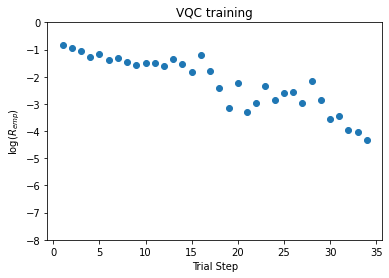

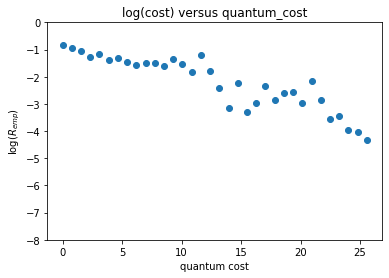

In [16]:
# Plot loss
loss_png = f"{VQC_OUT}/{TEAM_NAME}_loss.png"

fig, ax = plt.subplots()
ax.set_title("VQC training")
ax.set_xlabel("Trial Step")
ax.set_ylabel("$\log(R_{emp})$")
ax.plot(range(1, len(costs)+1), np.log(costs), 'o')
# ax.plot(range(1, iterations + 1), np.log(cost_estimates), 'o')
# ax.plot(range(1, iterations + 1), np.log(ave_cost_estimates), 'o')
ax.set_ylim(-8,0)
plt.savefig(loss_png)
plt.show()

fig, ax = plt.subplots()
ax.set_title("log(cost) versus quantum_cost")
ax.set_xlabel("quantum cost")
ax.set_ylabel("$\log(R_{emp})$")
ax.plot(np.arange(iterations + 1)*batch_size*(0.3 + 0.00035*shots), np.log(costs), 'o')
ax.set_ylim(-8,0)
plt.savefig(loss_png)
plt.show()

In [17]:
# Load trained parameters
final_params = np.loadtxt(params_csv)

In [18]:
# Calculate accuracy
Y_pred = np.zeros(shape=Y_test.shape)

for ind, x in enumerate(X_test):

    # How many of the qubit states are orthogonal?
    bprobs = qnode_local(final_params, x)  # probabilities for each basis state
    cprobs = (bprobs[0] + bprobs[1], bprobs[2] + bprobs[3])  # probabilities for each eigenvalue of Z_1 I_2 (Note the change from Havlicek et al.)

    # out of the majority of the number shots,
    # classify +1 for orthogonal and -1 for correspondence
    if cprobs[0] >= 0.5:
        Y_pred[ind] = 1.0
    else:
        Y_pred[ind] = -1.0

preds = [1 if Y_pred[i] == Y_test[i] else 0 for i in range(len(Y_pred))]

n_preds = len(Y_pred)
n_correct = sum(preds)
n_incorrect = n_preds - n_correct
accuracy = n_correct / n_preds

print(f"Accuracy: {round(accuracy*100,2)}%")
print(f"{n_incorrect} incorrect out of {n_preds}.")

Accuracy: 100.0%
0 incorrect out of 50.
